# 2019 NYC Yellow Taxi Trip Duration Prediction

Author by Zehao Guan (zehaog), Anqi Wang (anqiw2).

The goal of our project is to predict the duration length of taxi trip using some regression models and do experiments with the first quarter of 2019 NYC Yellow Taxi Trip dataset.

The code implementations are included in this [link](https://github.com/zach96guan/15-688_PDS_Project). And project video is uploaded [here](https://youtu.be/7XSPu7HTbsk).

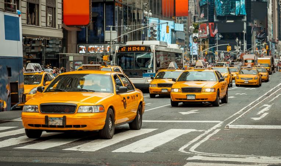


# Contents

- Motivation
- Preprocessing
    - Data Extraction
    - Data Description
    - Data Cleaning
- Data Analysis
- Feature Engineering
- Model
    - Data Splitting
    - Model Selection
        - Linear Regression
        - Random Forest
        - Gradient Boost
        - XgBoost
        - Neural Networks
    - Evaluation
- Summary
- Reference


# Motivation

Motivated by the homework 2, analysis and visualization on time series data of buses in Pittsburgh; Also we get some insights from a Kaggle competition, predict duration and total fare given pre-curated NYC taxi data.

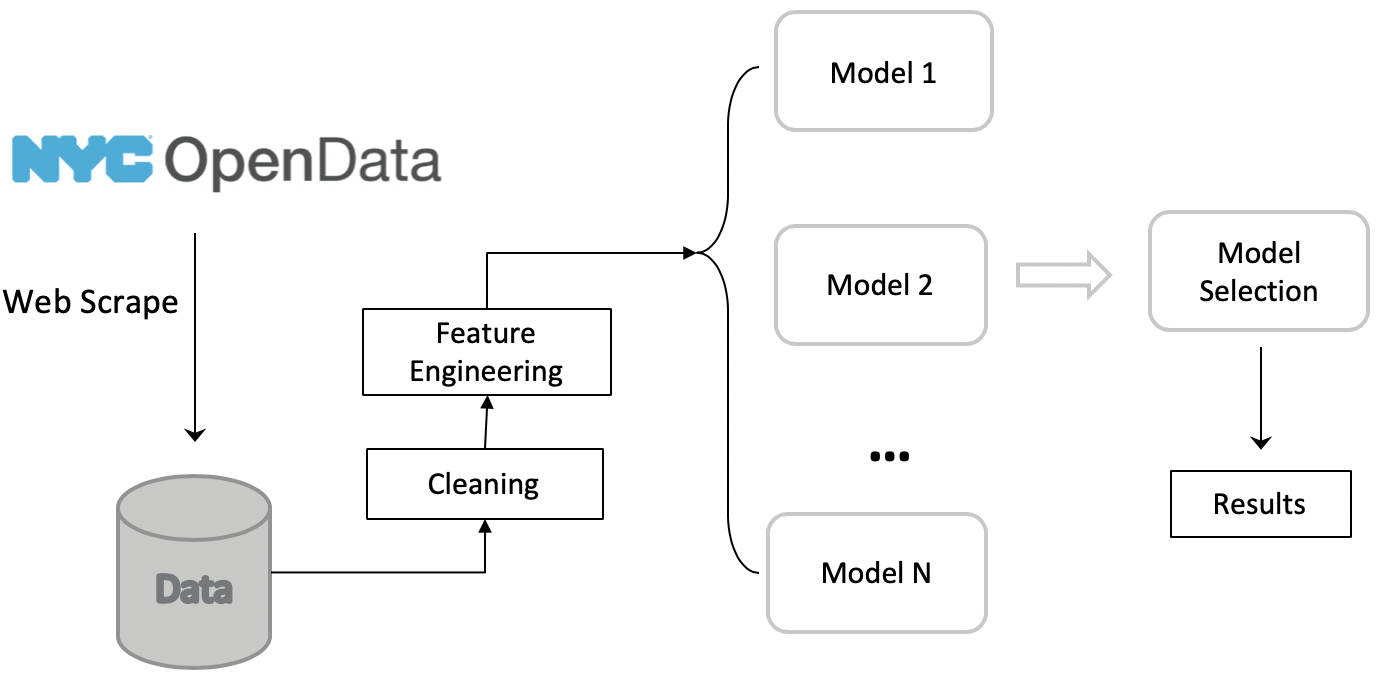

## Tools & Libraries

In [1]:
import numpy as np
import pandas as pd
import csv
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import patsy
import xgboost as xgb

from collections import Counter, defaultdict
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from scipy.stats import lognorm
from yellowbrick.regressor import ResidualsPlot

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow import keras
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization

sns.set_style('whitegrid')

# Preprocessing

## Data Extraction

Similar to the homework about web scraping with Yelp API, we write function to extract the JSON format data from websites. We set right values of limit and offset parameters to get all queried records, and return Pandas dataframe for the conveniece of data preprocessing.

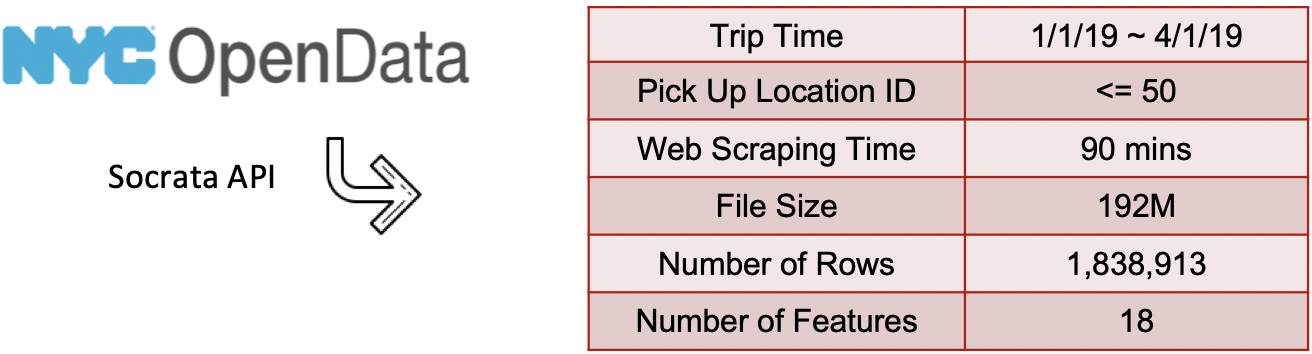

In [2]:
# 2019 Yellow Taxi Trip Data
def extract_data(url, query):
    new_url = url + query
    df = pd.DataFrame()
    
    i = 0
    cur_page = new_url + "&$limit=1000&$offset=" + str(i)
    cur_data = pd.read_json(cur_page)
    while len(cur_data) >= 1000:
        df = df.append(cur_data, sort=True)
        i += 1000
        cur_page = new_url + "&$limit=1000&$offset=" + str(i)
        cur_data = pd.read_json(cur_page)
        
        if i % 4e5 == 0:
            print("{} records have been extracted at {}.".format(i, datetime.now().time()))
    
    if len(cur_data) > 0:
        df = df.append(cur_data, sort=True)
    
    return df

Define functions to save/read data from generated .csv files. For the get data function, it takes around one and half an hour to successfully extract all NYC yellow taxi trip data in the first quarter of 2019.

In [3]:
def save_to_csv(df, fileName="./data/myData.csv"):
    df.to_csv(fileName)

In [4]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [5]:
def get_data():
    url = "https://data.cityofnewyork.us/resource/2upf-qytp.json?"
    # pickup time: Jan. ~ June, pickup location: <= 50
    query = "$where=tpep_pickup_datetime between '2019-01-01' and '2019-04-01' and PULocationID<=50"
    query = query.replace(" ", "%20")
    print(url + query)  # first page

    print("Start time: ", datetime.now().time())
    df = extract_data(url, query)
    print("End time: ", datetime.now().time())

    save_to_csv(df)

## Data Description

On the NYC Open Data website, there is an [attachment](https://data.cityofnewyork.us/api/views/2upf-qytp/files/4a7a18af-bfc8-43d1-8a2e-faa503f75eb5?download=true&filename=data_dictionary_trip_records_yellow.pdf) that talks about the columns information about the dataset, listed as the following table.


| **Column Name** | **Information** | 
|----------|:-------------|
| VendorID | A code indicating the LPEP provider that provided the record. (1=Creative Mobile Technologies, LLC 2=VeriFone Inc)|
| tpep_pickup_datetime | The date and time when the meter was engaged.|
| tpep_dropoff_datetime | The date and time when the meter was disengaged.|
| Passenger_count| The number of passengers in the vehicle.|
| Trip_distance | The elapsed trip distance in miles reported by the taximeter.|
| PULocationID | TLC Taxi Zone in which the taximeter was engaged|
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged|
| RateCodeID | The final rate code in effect at the end of the trip. (1=Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride)|  
| Payment_type| A numeric code signifying how the passenger paid for the trip. (1=Credit card, 2=Cash 3=No charge, 4=Dispute, 5=Unknown, 6=Voided trip)|
| Fare_amount | The time-and-distance fare calculated by the meter.|
|Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1.0 rush hour and overnight charges.|
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use.|
| Improvement_surcharge | \$0.30 improvement surcharge assessed on hailed trips at the flag drop.|
| Tip amount | This field is automatically populated for credit card tips. Cash tips are not included.|
| Tolls_amount | Total amount of all tolls paid in trip.|
| Total_amount | The total amount charged to passengers. Does not include cash tips.|

## Data Cleaning

For the initial stage of data cleaning, we define several functions to preprocess the raw dataset. Afterwards we will use the output "myData.csv" to do data analysis, in seek of some data insights about what model we could possibly utilize in the next step.

In [6]:
def drop_useless_columns(df):
    # get rid of useless columns
    df = df.drop(columns=["congestion_surcharge", "store_and_fwd_flag"])
    return df

In [7]:
def convert_to_timestamp(df):
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    return df

In [8]:
def create_duration_colum(df):
    # create "duration" column from pickup and dropoff datetime
    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    
    # convert to minutes
    df["duration"] = df['duration'].dt.total_seconds() / 60
    return df

All the generated data are stored in the "./data/" directory. Consider the size of .csv files is too large, we git ignore *.csv files when we push to the repo.

In [9]:
path = "./data/myData.csv"

df = read_from_csv(path)
df = drop_useless_columns(df)
df = convert_to_timestamp(df)
df = create_duration_colum(df)

df.columns

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['dolocationid', 'extra', 'fare_amount', 'improvement_surcharge',
       'mta_tax', 'passenger_count', 'payment_type', 'pulocationid',
       'ratecodeid', 'tip_amount', 'tolls_amount', 'total_amount',
       'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'trip_distance',
       'vendorid', 'duration'],
      dtype='object')

In [10]:
df.head(10)

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid,duration
0,1,0.0,20.0,0.3,0.5,1,1,1,5,1.00,0.00,21.80,2019-01-01 02:19:32,2019-01-01 02:19:27,0.0,2,0.083333
1,1,0.0,85.0,0.3,0.0,1,1,1,5,2.00,0.00,87.30,2019-01-01 05:52:53,2019-01-01 05:52:45,0.0,2,0.133333
2,1,0.0,80.0,0.3,0.0,1,1,1,5,0.00,0.00,80.30,2019-01-01 06:23:23,2019-01-01 06:22:24,0.0,2,0.983333
3,1,0.0,80.0,0.3,0.0,2,1,1,5,16.06,0.00,96.36,2019-01-01 08:13:01,2019-01-01 08:12:51,0.0,2,0.166667
4,1,0.0,160.0,0.3,0.5,2,1,1,5,0.00,0.00,160.80,2019-01-01 08:14:53,2019-01-01 08:14:48,0.0,2,0.083333
5,1,0.0,2.5,0.3,0.5,3,2,1,1,0.00,0.00,3.30,2019-01-01 10:10:33,2019-01-01 10:10:30,16.9,1,0.050000
6,1,0.0,0.0,0.3,0.0,3,3,1,5,0.00,16.26,16.56,2019-01-01 10:11:32,2019-01-01 10:10:52,16.9,1,0.666667
7,1,0.0,0.0,0.3,0.0,3,3,1,5,0.00,16.26,16.56,2019-01-01 10:13:13,2019-01-01 10:12:05,16.9,1,1.133333
8,1,0.0,120.0,0.3,0.0,3,2,1,5,0.00,16.26,136.56,2019-01-01 10:14:35,2019-01-01 10:13:44,16.9,1,0.850000
9,1,0.0,90.0,0.3,0.0,3,1,1,5,18.06,0.00,108.36,2019-01-01 12:16:23,2019-01-01 12:16:18,0.0,2,0.083333


In [11]:
# save_to_csv(df, "./data/processed_myData.csv")
len(df)

1838913

# Data Analysis

In this notebook, we wish to explore the NYC taxi trip dataset further. We take the .csv file from initial preprocessing as input, and use statistical or visualization methods to have a close look at the column features. This will be helpful for us to modify the project direction in time, and also of great importance to select the fitting model for prediction step.

For the initial preprocessing, we simply drop some useless columns, convert data types like changing pickup and dropoff time from object to timestamp, create new **duration** feature, and drop the rows containing NaN. And we use these processed data for the data analysis step.

In [ ]:
file_path = "./data/processed_myData.csv"

df = pd.read_csv(file_path, index_col=0)
df = df.reset_index(drop=True)

# Explore Features

Now, we will in turn explore the column features in given dataset. We intend to use some statistical methods, and several visualization tools we learnt in class to observe the distribution of data.

## Trip Duration

This is the very significant feature, and we plan to predict it first by using some regression models. Also, it's the key explanable variable for us to use if we wish to predict the total amount or tip percentage.

In [ ]:
trip_dur_secs = pd.to_timedelta(df['duration']).dt.total_seconds()
trip_dur_secs.head(10)

According to the duration length of each trip, we could classify them into short trip (<15mins), medium trip (15~40mins) and long trip (>40mins). We use pie plot to see the percentage, and it will help determine which rows can be considered as outliers, when we want to do further data cleaning.

In [ ]:
trip_dur_mins = trip_dur_secs / 60
count_mins = Counter()

"""
short_trip: duration less than 20 minutes
medium_trip: duration greater than or equal to 20 mins but less than 40 mins
long trip: duration greater than or equal to 40 mins but less than 90mins
others: duration longer than or equal ot 90mins
"""
for dur_mins in trip_dur_mins:
    if dur_mins < 15:
        count_mins['short_trip'] += 1
    elif dur_mins < 40:
        count_mins['medium_trip'] += 1
    else:
        count_mins['long_trip'] += 1

print(count_mins)
key_value_pairs = count_mins.items()

fig, ax = plt.subplots()
ax.pie([x[-1] for x in key_value_pairs], labels=[x[0] for x in key_value_pairs], explode=(0.1, 0.1, 0.1), autopct='%1.1f%%')
ax.set_title('Trip Duration')
plt.show()

## Passenger Count

Usually, the number of passengers for a yellow taxi is 1~6. But we find in the dataset, there exist some rows of which the passenger count is zero, and we should get rid of them. To make the data distribution more consistent, for those where the count is bigger than 4, we could gently ignore them.

In [ ]:
passenger_count = df['passenger_count']
passenger_count.plot.hist(bins=np.arange(10), color='g')

In [ ]:
passenger_count.head(10)

In [ ]:
# find some rows with 0 or more than 6 passengers, should get rid of them
passenger_counter = Counter()
for cnt in passenger_count:
    if cnt == 0 or cnt >= 7:
        continue
    passenger_counter[cnt] += 1

count_items = passenger_counter.items()
print(count_items)

fig, ax = plt.subplots()
ax.pie([x[-1] for x in count_items], labels=[x[0] for x in count_items], explode=[0.2] * len(count_items), autopct='%1.1f%%')
ax.set_title('Passenger Count')
plt.show()

## Trip Distance

In yellow taxi trip dataset, we are given the trip distance, instead of the pickup/dropoff longitude and latitude in green taxi trip dataset. Similar as we analyze the trip duration, this time we define the trip length based on the geographical distance.

In [ ]:
trip_dist = df['trip_distance']
trip_dist.head(10)

In [ ]:
trip_dist.describe()

We try to use box plots to look at the distance distribution in detail. Visualization by *boxplot* from pyplot will help us clearly see the numerical difference of trip distance in comparison to the pie plot.

In [ ]:
trip_dist_counter = defaultdict(list)

for d in trip_dist:
    # only consider trip distance less than 30 miles
    if d < 5:
        trip_dist_counter['<5'].append(d)
    elif d < 10:
        trip_dist_counter['5-10'].append(d)
    elif d < 20:
        trip_dist_counter['10-20'].append(d)
    elif d <= 30:
        trip_dist_counter['<30'].append(d)

dist_items = sorted(trip_dist_counter.items(), key=lambda x:x[-1])
plt.boxplot([x[-1] for x in dist_items], labels=[x[0] for x in dist_items])
plt.show()

In [ ]:
trip_dist_counter2 = {}
for k in trip_dist_counter:
    trip_dist_counter2[k] = len(trip_dist_counter[k])

print(trip_dist_counter2)
    
count_items = trip_dist_counter2.items()
fig, ax = plt.subplots()
ax.pie([x[-1] for x in count_items], labels=[x[0] for x in count_items], explode=[0.2] * len(count_items), autopct='%1.1f%%')
ax.set_title('Trip Distance')
plt.show()

Do preprocessing such as using log-normed values. This makes a lot more sense, since continuous probability distribution is prone to perform better if we do linear regression or other advanced models.

In [ ]:
trip_dist_mean = trip_dist.mean()
trip_dist_std = trip_dist.std()

# remove outliers based on 3-sigma rule
trip_dist = trip_dist[(trip_dist - trip_dist_mean).abs() < 3 * trip_dist_std]
trip_dist.plot.hist()  # should focus on trips with distance less than 8 miles

In [ ]:
# log-normal fit
shape, location, scale = lognorm.fit(trip_dist, scale=trip_dist_mean, loc=0)
normed = lognorm.pdf(np.arange(9), shape, location, scale)
plt.plot(np.arange(9), normed)
plt.show()

## Rate Code

The meaning of 'ratecodeid' column is the final rate code in effect at the end of the trip. The mapping relationships are listed in the following 'code_map'.

In [ ]:
rate_code = df['ratecodeid']
rate_code_counter = Counter(rate_code)
print(rate_code_counter)

In [ ]:
code_map = {
    1: 'Standard',
    2: 'JFK',
    3: 'Newark',
    4: 'Nassau or Westchester',
    5: 'Negotiated Fare',
    6: 'Group Ride',
    99: 'others'
}

total = sum(rate_code_counter.values())
for k, v in rate_code_counter.items():
    percentile = 100 * v / total
    print("{}% trips are {}".format(round(percentile, 3), code_map[k]))

In [ ]:
df_rate_code = pd.DataFrame(rate_code_counter.values(), index=rate_code_counter.keys())
ax = df_rate_code.plot.bar(rot=0)

## Payment Types

For the payment method, there are totally four different types. Customers mainly use credit card, and less than one third bring cash. Thus, we merely select the data where payment type code is 1 or 2.

In [ ]:
payment_types = {1: "Credit card", 2: "Cash", 3: "No charge", 4: "Dispute"}
x = [payment_types[idx] for idx in list(df["payment_type"].value_counts().index)]
y = list(df["payment_type"].value_counts().values)

dic = {}
for i in range(len(x)):
    dic[x[i]] = y[i]
print(dic)

fig, ax = plt.subplots()
ax.pie(y, labels=x, explode=(0.1, 0.1, 0.1, 0.1), autopct='%1.1f%%')
ax.set_title('Payment Type')
plt.show()

## Fare Amount

Likewise, we use histogram and log-normed curve to explore the fare amount column.

In [12]:
fare_amount = df['fare_amount']
ax = fare_amount.hist(bins=100)
ax.set_xlabel("fare_amount")
ax.set_ylabel("Number of Rides")
plt.show()

NameError: name 'df' is not defined

In [13]:
fare_amount_mean = fare_amount.mean()
fare_amount_std = fare_amount.std()
fare_amount = fare_amount[(fare_amount - fare_amount_mean).abs() < 3 * fare_amount_std]
fare_amount.hist(bins=100)

NameError: name 'fare_amount' is not defined

In [ ]:
shape, location, scale = lognorm.fit(fare_amount, scale=fare_amount_mean, loc=0)
normed = lognorm.pdf(np.arange(100), shape, location, scale)
plt.plot(np.arange(100), normed)
plt.show()

For these 'amount' related columns, their values sum up to the 'total amount' in dataframe. They can be taken as bool or categorical type of data, which are also important in duration prediction.

## Tolls Amount

In [ ]:
ax = df['tolls_amount'].hist(bins=100)
ax.set_yscale('log')
ax.set_xlabel("tolls_amount")
ax.set_ylabel("Number of Rides")
plt.show()

## Surcharge

In [ ]:
labels = [str(i) for i in list(df["improvement_surcharge"].value_counts().index)]
y = list(df["improvement_surcharge"].value_counts().values)

plt.bar(labels, y, align='center')
plt.xlabel('')
plt.ylabel('')

for a,b in zip(labels, y):
    plt.text(a, b, str(b))
    
plt.show()

## Extra

In [ ]:
print(df['extra'].describe())

ax = df['extra'].hist(bins=20)
ax.set_xlabel("extra")
ax.set_ylabel("Number of Rides")
plt.show()

## Feature Engineering

Feature engineering is the way to take advantage of domain knowledge of the data to create new features that make machine learning algorithm works. This is very important in the data science project. Here we think of use feature engineering to improve the performance of metrics and develop better model. 

After the exploration and analysis of the column features and data distribution, we modify the original preprocessing methods. This will remove more data points (known as outliers or bad, ignorable rows) to make the whole dataset consistent and well-distributed.

In [12]:
def drop_outliers(df):
    # drop rows with 0.0 total amount or 0.0 trip distance
    df = df[(df['total_amount'] > 0.0) & (df['trip_distance'] > 0.0)]
    
    # trip duration should be less than or equal to 40 minutes
    df = df[df['duration'] <= 90]
    
    # count of passengers should be positive and less than 5
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 4)]
    
    # trip distance between 1 and 20 miles
    df = df[(df['trip_distance'] >= 1.) & (df['trip_distance'] <= 20)]
    
    # only reserve standard code trip
    df = df[df['ratecodeid'] == 1]
    
    # get rid of payment type that is "dispute" or "no charge"
    df = df[(df['payment_type'] == 1) | (df['payment_type'] == 2)]
    
    df = df.dropna().reset_index(drop=True)
    return df

In [13]:
df = drop_outliers(df)
len(df)

1196083

In [14]:
df.head(10)

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid,duration
0,1,0.0,2.5,0.3,0.5,3,2,1,1,0.00,0.0,3.30,2019-01-01 10:10:33,2019-01-01 10:10:30,16.90,1,0.050000
1,265,0.0,24.5,0.3,0.5,1,2,1,1,0.00,0.0,25.30,2019-01-02 15:11:48,2019-01-02 14:50:55,7.92,2,20.883333
2,249,1.0,41.0,0.3,0.5,1,2,1,1,0.00,17.5,60.30,2019-01-09 17:23:39,2019-01-09 16:55:48,14.97,2,27.850000
3,237,1.0,8.5,0.3,0.5,1,1,1,1,1.00,0.0,11.30,2019-01-09 19:23:18,2019-01-09 19:13:21,2.01,2,9.950000
4,265,0.0,7.5,0.3,0.5,1,1,1,1,1.66,0.0,9.96,2019-01-11 07:52:27,2019-01-11 07:43:43,1.04,2,8.733333
5,1,1.0,2.5,0.3,0.5,4,1,1,1,39.00,0.0,43.30,2019-01-11 17:37:53,2019-01-11 17:37:51,14.60,1,0.033333
6,1,0.0,13.0,0.3,0.5,1,2,1,1,0.00,0.0,13.80,2019-01-16 15:11:33,2019-01-16 14:59:21,3.31,2,12.200000
7,265,0.0,38.5,0.3,0.5,1,2,1,1,0.00,0.0,39.30,2019-01-22 10:10:52,2019-01-22 09:32:00,11.20,1,38.866667
8,1,1.0,2.5,0.3,0.5,1,2,1,1,0.00,0.0,4.30,2019-01-25 16:35:23,2019-01-25 16:35:18,17.40,1,0.083333
9,1,1.0,2.5,0.3,0.5,1,2,1,1,0.00,0.0,4.30,2019-01-25 16:37:27,2019-01-25 16:37:23,17.40,1,0.066667


### Add Features

In this section, we first create some time related features which are derived from pickup time. We hypothesize that different day during a week or month or year and different hour in a day will have influence on trip duration. So we create following features:

- hour_or_day: int [0-23] indicating which hour in the day of pickup time
- day_of_week: indicating which day in the week, 0: Sunday, 1: Monday, 2: Tuesday, 3: Wednesday, 4: Thursday, 5: Friday, 6: Satureday
- day_of_month: an integer from 1 to 30 or 31, indicating which day in the month
- week_of_year: indicating which week in the year

We also create a tip related feature which represent tip proportion of total amount.

In [ ]:
df["hour_of_day"] = df.tpep_dropoff_datetime.dt.hour
df["day_of_week"] = df.tpep_dropoff_datetime.dt.weekday
df["day_of_month"] = df.tpep_dropoff_datetime.dt.day
df["week_of_year"] = df.tpep_dropoff_datetime.dt.weekofyear

df['tip_proportion'] = df.tip_amount / df.total_amount

### Correlation between Features

Second, we use [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF) and correlation heatmap to check whether there exist correlation between two independent variables. Then we will drop one of them to maintain independence between features.

In [ ]:
# drop all 1 column "ratecodeid" and datetime columns
new_df = df.drop(columns=["tpep_dropoff_datetime", "tpep_pickup_datetime", "ratecodeid"])

In [ ]:
columns = new_df.columns.tolist()
columns.remove("duration")
features = "+".join(columns)

target = "duration"
y, X = patsy.dmatrices(target + '~' + features, new_df, return_type='dataframe')
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.T

vif

From above VIF score for each feature, we notice that "fare_amount", "total_amount" have relatively high VIF score, which indicates they may have high correlation. Next we check the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between each pair of feature.

In [ ]:
pearson_score = new_df.corr(method ='pearson')
pearson_score

We can explicitly visualize the correlations by [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) from seaborn library.

In [ ]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(pearson_score,
            xticklabels=pearson_score.columns,
            yticklabels=pearson_score.columns,
            annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

We noticed that "trip_distance", "total_amount" and "fare_amount" have high correlation with each other. So we drop two of them to prevent from collinearity. Also, we should also drop the least important columns like "dolocationid" and "pulocationid".

In [ ]:
df = df.drop(columns=["total_amount",
                      "tpep_dropoff_datetime",
                      "tpep_pickup_datetime",
                      "ratecodeid",
                      "dolocationid",
                      "pulocationid"])

In [ ]:
df.columns

In [ ]:
df.head(10)

# Model

Our task is to build a regression model to predict the duration of a yellow taxi trip. We apply linear regression model as our baseline model. To capture the non-linear relationship between features and target, we further use XgBoost, Gradient Boost, Random Forest and Neural Networks for prediction. We implement parameter searching and tuning for those models to get the best results. We take root mean square error as evaluation metric. Finally, we plan to compare and analyze among different models.


## Data Splitting

After the feature engineering step, we use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to divide the processed dataframe into train set and test set two parts. In the **model.ipynb**, we will use the split data for validation and model selection.

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print("Train size: {}".format(len(X_train)))
print("Test size: {}".format(len(X_test)))

In [ ]:
save_to_csv(X_train, "./data/train.csv")
save_to_csv(X_test, "./data/test.csv")

We take the splited train and test dataset generated from the **preprocess.ipynb** as input.

In [ ]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [ ]:
train_path = './data/train.csv'
test_path = './data/test.csv'

X_train, X_test = read_from_csv(train_path, ), read_from_csv(test_path)
len(X_train), len(X_test)

In [ ]:
y_train, y_test = pd.DataFrame(X_train['duration']), pd.DataFrame(X_test['duration'])

X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

Here, we apply the [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) as the metric for regression.

In [ ]:
def get_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

## Model Selection

### Linear Regression

For linear regression model, we choose four different variations. The simplest version of linear model shows as follow:
$$ \hat y = w_{1}x_{1} + w_{1}x_{1} + ... w_{n}x_{n} + b $$

The cost function is:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) $$

For Ridge regression, the cost function consists of loss and regularization part. Regularization part equals to square of the magnitude of the coefficients:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) + \lambda \sum_{j=0}^{F}w_{j}^{2}$$

For Lasso regression, regularization part of cost function is sum of absolute value of weights. This L1 regularization can shrink and completely neglect some of the features:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) + \lambda \sum_{j=0}^{F}|w_{j}|$$

For [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) regression, it combines both L1 and L2 regularization into cost function.

Through the test, we find normalization will make performance worse, so we choose to use the default "normalize=False".

In [ ]:
# https://scikit-learn.org/stable/modules/linear_model.html
model_lr = LinearRegression().fit(X_train, y_train)
model_ridge = Ridge().fit(X_train, y_train)
model_lasso = Lasso().fit(X_train, y_train)
model_elasticnet = ElasticNet().fit(X_train, y_train)

In [ ]:
# Train
y_pred1 = model_lr.predict(X_train)
y_pred2 = model_ridge.predict(X_train)
y_pred3 = model_lasso.predict(X_train)
y_pred4 = model_elasticnet.predict(X_train)

train_loss1 = get_rmse(y_train, y_pred1)
train_loss2 = get_rmse(y_train, y_pred2)
train_loss3 = get_rmse(y_train, y_pred3)
train_loss4 = get_rmse(y_train, y_pred4)

print("Train Loss for Linear Regression: {}".format(train_loss1))
print("Train Loss for Ridge Regression: {}".format(train_loss2))
print("Train Loss for Lasso Regression: {}".format(train_loss3))
print("Train Loss for Elastic_Net Regression: {}".format(train_loss4))

In [ ]:
# Test
y_pred1 = model_lr.predict(X_test)
y_pred2 = model_ridge.predict(X_test)
y_pred3 = model_lasso.predict(X_test)
y_pred4 = model_elasticnet.predict(X_test)

test_loss1 = get_rmse(y_test, y_pred1)
test_loss2 = get_rmse(y_test, y_pred2)
test_loss3 = get_rmse(y_test, y_pred3)
test_loss4 = get_rmse(y_test, y_pred4)

print("Test Loss for Linear Regression: {}".format(test_loss1))
print("Test Loss for Ridge Regression: {}".format(test_loss2))
print("Test Loss for Lasso Regression: {}".format(test_loss3))
print("Test Loss for Elastic_Net Regression: {}".format(test_loss4))

In [ ]:
# Plot output, take "model_lr" as example
plt.scatter(np.arange(X_test.shape[0]), y_test, color='r', s=10)
plt.plot(np.arange(X_test.shape[0]), y_pred1, color='b', linewidth=0.1)

plt.xticks(())
plt.yticks(())
plt.show()

### Random Forest

Random forest builds on bagging by random selecting samples, features and getting result from random set of predictors.

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1, max_depth=10, verbose=True).fit(X_train, y_train)

In [ ]:
# Train
y_pred = model_rf.predict(X_train)
train_loss_rf = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss_rf))

In [ ]:
# Test
y_pred = model_rf.predict(X_test)
test_loss_rf = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss_rf))

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
from sklearn.tree import export_graphviz
from graphviz import Source
estimator = model_rf.estimators_[1]

from IPython.display import SVG
graph = Source(export_graphviz(estimator, out_file=None, feature_names=X_train.columns))
SVG(graph.pipe(format='svg'))

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train.columns.tolist()

plt.title("Feature importances", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], color="b",align="center")
plt.xticks(range(X_train.shape[1]), [columns[idx] for idx in indices], rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Gradient Boost

The objective of gradient boost is to minimize the loss of the model by adding decision tree one at a time using gradient descent. 

In [ ]:
model_gb = GradientBoostingRegressor(verbose=True).fit(X_train, y_train)

In [ ]:
# Train
y_pred = model_gb.predict(X_train)
train_loss_gb = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss_gb))

In [ ]:
# Test
y_pred = model_gb.predict(X_test)
test_loss_gb = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss_gb))

### XGBoost

Xgboost uses K additive functions to predict the output. The output is sum of scores predicted by each of the tree. Instead learning weights like in linear regression, XgBoost is learning functions (trees) in each iteration.

The objective funcion consists of train loss and regularization part. The training process starts from constant output. At each time add a new function which minimize the above objective function:

$$ Obj^{t} = \sum_{i=1}^{n} l(y_{i}, \hat {y_{i}}^{t-1}+f_{t}(x_{i})) + \Omega (f_{t}) \quad f_{t} \subseteq F \, (all \, regression \, trees) $$

In [ ]:
params = { 
    'booster': 'gbtree',
    'objective':'reg:linear',
    'learning_rate': 0.2,
    'n_estimators': 200,
    'objective': 'reg:linear',  
    'gamma': 0.3,                  # control pruning
    'max_depth':5 ,               
    'lambda': 2,                   # L2 parameter
    'subsample': 0.8,              # random sample 
    'colsample_bytree': 0.7,       # col sample when generate tree
    'min_child_weight': 1,
    'silent': 0,
    'reg_alpha': 0
}

In [ ]:
model_xgboost = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        silent=params['silent'],
        max_depth=params['max_depth'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha']
    )

model_xgboost.fit(X_train, y_train)

In [ ]:
# Train
y_pred = model_xgboost.predict(X_train)
train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

In [ ]:
# Test
y_pred = model_xgboost.predict(X_test)
test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

#### Grid Search Parameters for Xgboost

Considering time complexity and effect on result, we choose "learning rate", "number of estimators" and "gamma" as tunning parameter. 

In [ ]:
# A parameter grid for XGBoost
params = {
        'booster': 'gbtree',
        'objective':'reg:squarederror',
        'max_depth': 5,
        'lambda': 2,                   # L2 parameter
        'subsample': 0.8,              # random sample
        'colsample_bytree': 0.7,       # col sample when generate tree
        'min_child_weight': 1,
        'reg_alpha': 0,
        'verbosity':1
    }

search_params={
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300],
        'gamma': [1, 2, 5, 10],
    }

model_xgboost = xgb.XGBRegressor(
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        verbosity=params['verbosity']
    )

cv_folders = 5
gs = GridSearchCV(model_xgboost, search_params, scoring="neg_mean_absolute_error", cv=cv_folders, verbose=2)
gs.fit(X_train, y_train)

In [ ]:
print(gs.scorer_, gs.best_estimator_, gs.best_params_, gs.best_score_)

In [ ]:
# best model: gs.best_estimator_
best_xgboost = xgb.XGBRegressor(
                base_score=0.5,
                booster='gbtree',
                colsample_bylevel=1,
                colsample_bynode=1,
                colsample_bytree=0.7,
                gamma=5,
                importance_type='gain',
                learning_rate=0.2,
                max_delta_step=0,
                max_depth=5,
                min_child_weight=1,
                missing=None,
                n_estimators=300,
                n_jobs=-1,
                nthread=None,
                objective='reg:squarederror',
                random_state=0,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                seed=None,
                silent=None,
                subsample=0.8,
                verbosity=1)

best_xgboost.fit(X_train, y_train)

y_pred = best_xgboost.predict(X_train)
train_loss_xgboost = get_rmse(y_train, y_pred)
y_pred = model_xgboost.predict(X_test)
test_loss_xgboost = get_rmse(y_test, y_pred)

In [ ]:
print(best_xgboost.feature_importances_)
xgb.plot_importance(best_xgboost)

### Neural Networks

In [ ]:
# https://keras.io/getting-started/sequential-model-guide/
model_nn = models.Sequential()
model_nn.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(32, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(8, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1))

optimizer = optimizers.Adam(lr=1e-4)
model_nn.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [ ]:
model_nn.summary()

In [ ]:
history = model_nn.fit(
                x=X_train,
                y=y_train,
                validation_data=(X_test, y_test), 
                batch_size=256,
                epochs=8,
                shuffle=True,
                verbose=1
            )

In [ ]:
train_loss_nn = history.history['loss']
test_loss_nn = history.history['val_loss']
epochs = np.arange(len(train_loss_nn))

plt.plot(epochs, train_loss_nn, 'r')
plt.plot(epochs, test_loss_nn, 'b')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

## Evaluation

In [ ]:
print('Train RMSE score for the Linear Regression model is : %f'%(train_loss1))
print('Train RMSE score for the Ridge model is : %f'%(train_loss2))
print('Train RMSE score for the Lasso model is : %f'%(train_loss3))
print('Train RMSE score for the ElasticNet model is : %f'%(train_loss4))
print('Train RMSE score for the Random Forest model is : %f'%(train_loss_rf))
print('Train RMSE score for the Gradient Boost model is : %f'%(train_loss_gb))
print('Train RMSE score for the Xgboost model is : %f'%(math.sqrt(train_loss_xgboost)))
print('Train RMSE score for the Neural Network is : %f'%(math.sqrt(train_loss_nn[-1])))

In [ ]:
print('Test RMSE score for the Linear Regression model is : %f'%(test_loss1))
print('Test RMSE score for the Ridge model is : %f'%(test_loss2))
print('Test RMSE score for the Lasso model is : %f'%(test_loss3))
print('Test RMSE score for the ElasticNet model is : %f'%(test_loss4))
print('Test RMSE score for the Random Forest model is : %f'%(test_loss_rf))
print('Test RMSE score for the Gradient Boost model is : %f'%(test_loss_gb))
print('Test RMSE score for the Xgboost model is : %f'%(math.sqrt(test_loss_xgboost)))
print('Test RMSE score for the Neural Network is : %f'%(math.sqrt(test_loss_nn[-1])))

# Summary

In this project, we extract yellow taxi data from NYC Open Data, conduct data preprocessing, data analysis, feature engineering and implement a series of models to predict taxi trip duration. Based on our experiments, we obtain the following conclusions:

- Linear regression and its variations are treated as our baseline model. On both train set and test set, they get higher RMSE score. Among simple Linear Regression, Ridge, Lasso and Elastic Net, Ridge regression has slightly better performance over the test set.

- Compared with Linear Regression, Random Forest model has around 15% lower RMSE both on train set and test set.

- Performance of Gradient Boost model is worse than random forest which may cause from the inappropriate selection of some hyper-parameters. 

- Xgboost model achieves lowest RMSE score on train set and test set. It is an optimized distributed Gradient Boosting method which leads to both greater metrics performance and less time cost.

During the whole project, we experience the full data science development cycle. We notice the importance of data exploration and data cleaning before building models. And after understanding data distribution and building baseline, we furthermore improve our feature selection based on the baseline results until we get the optimal features. Finally, we utilize optimal feature space to construct model and achieve the best result. For future work, we will go deeper with the algorithm in each model and try to apply them in different aspects.


# Reference

1. [NYC Open Data 2019 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp)
2. [New York City Taxi Trip Duration Kaggle Competition](https://www.kaggle.com/c/nyc-taxi-trip-duration)
3. [Socrata API](https://dev.socrata.com/)
4. [Fare and Duration Prediction: A Study of New York City Taxi Rides](http://cs229.stanford.edu/proj2016/report/AntoniadesFadaviFobaAmonJuniorNewYorkCityCabPricing-report.pdf)
5. [Keras Documentation](https://keras.io/getting-started/sequential-model-guide/)